In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
plot_dir = "../../../results/plots/"
COORDINATES = ["chrom", "pos", "ref", "alt"]
data_path = "gnomad/merged/all"
model_paths = {
    "GPN-MSA": "multiz100way/89/128/64/True/defined.phastCons.percentile-75_0.05_0.001/medium/0.1/42/30000/True/True/True",
    "MSA": "msa_multiz100way/89",
}
models = list(model_paths.keys())

def format_number(num):
    """
    Converts a number into a more readable format, using K for thousands, M for millions, etc.
    Args:
    - num: The number to format.
    
    Returns:
    - A formatted string representing the number.
    """
    if num >= 1e9:
        return f'{num/1e9:.1f}B'
    elif num >= 1e6:
        return f'{num/1e6:.1f}M'
    elif num >= 1e3:
        return f'{num/1e3:.1f}K'
    else:
        return str(num)

In [3]:
# load data
V = pl.read_parquet(f"../../../results/{data_path}/test.parquet", columns=COORDINATES + ["AF"])
len(V)

569854116

In [4]:
# load models
for model, path in model_paths.items():
    V = V.with_columns(
        pl.read_parquet(f"../../../results/preds/results/{data_path}/{path}.parquet", columns="score")["score"].alias(model)
    )

In [5]:
# filter bi-allelic
V = V.unique(subset=["chrom", "pos"], keep="none")
V.shape

(488699771, 7)

In [6]:
# fold AF and scores
V = V.with_columns(
    pl.when(pl.col("AF") <= 0.5).then(pl.col("AF")).otherwise(1 - pl.col("AF")).alias("MAF")
)
for model in models:
    V = V.with_columns(
        pl.when(pl.col("AF") <= 0.5).then(pl.col(model)).otherwise(-pl.col(model))
    )
V

chrom,pos,ref,alt,AF,GPN-MSA,MSA,MAF
str,i64,str,str,f64,f32,f64,f64
"""1""",10111,"""C""","""A""",0.000023,-0.017578,0.0,0.000023
"""1""",10131,"""C""","""A""",0.000009,-0.347656,0.0,0.000009
"""1""",10132,"""T""","""C""",0.000263,0.884766,0.0,0.000263
"""1""",10139,"""A""","""T""",0.000017,-0.432617,0.0,0.000017
"""1""",10140,"""A""","""C""",0.000028,0.074219,0.0,0.000028
"""1""",10141,"""C""","""G""",0.00002,-0.496094,0.0,0.00002
"""1""",10145,"""A""","""T""",0.000177,-0.43457,0.0,0.000177
"""1""",10147,"""C""","""G""",0.004386,-0.486328,0.0,0.004386
"""1""",10149,"""C""","""A""",0.000059,-0.246094,0.0,0.000059


In [7]:
V = V.drop_nulls(subset=models)
V.shape

(488699715, 8)

## First version

In [31]:
breaks = np.arange(-15.5, 12.5)
bins = breaks + 0.5

dfs = []

for model in models:
    V_m = V.with_columns(
        (pl.col(model).cut(breaks, include_breaks=True).struct.field("brk") - 0.5).alias("score_bin")
    ).filter(pl.col("score_bin").is_in(bins))
    df = (
        V_m.group_by("score_bin")
        .agg(pl.mean("MAF").alias("MAF-mean"), pl.count("MAF").alias("MAF-count"))
        .sort("score_bin")
        .to_pandas()
    )
    df["Model"] = model
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df

,score_bin,MAF-mean,MAF-count,Model
0,-14.0,0.000009,76,GPN-MSA
1,-13.0,0.000061,11143,GPN-MSA
2,-12.0,0.000040,63281,GPN-MSA
3,-11.0,0.000081,155347,GPN-MSA
4,-10.0,0.000147,265247,GPN-MSA
5,-9.0,0.000236,431772,GPN-MSA
6,-8.0,0.000444,756581,GPN-MSA
7,-7.0,0.000794,1538679,GPN-MSA
8,-6.0,0.001151,3788514,GPN-MSA
9,-5.0,0.001504,9146503,GPN-MSA


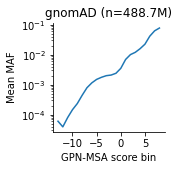

In [33]:
plt.figure(figsize=(2,2))
g = sns.lineplot(
    #data=df[df["MAF-count"] >= 1000].replace("MSA", "MSA column"),
    data=df[(df["MAF-count"] >= 1000) & (df.Model=="GPN-MSA")],
    x="score_bin",
    y="MAF-mean",
    #hue="Model",
    errorbar=None,
    #palette=sns.color_palette("tab20")[:2],
)
plt.xlabel("GPN-MSA score bin")
#plt.xlabel("Log-likelihood ratio")
plt.ylabel("Mean MAF")
#title = f"gnomAD bi-allelic\nn={format_number(len(V))}"
title = f"gnomAD (n={format_number(len(V))})"
plt.title(title)
#sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.despine();
g.set(yscale='log');
plt.xticks([-10, -5, 0, 5]);
#plt.savefig(plot_dir + "gnomad_full_score_vs_maf.pdf", bbox_inches="tight")

## Quantile version

In [8]:
generator = np.random.default_rng(seed=42)
random_noise = generator.normal(0, 1e-8, len(V))

In [9]:
len(V) / 10_000

48869.9715

In [10]:
len(V) / 100_000

4886.99715

In [17]:
quantiles = np.logspace(-6, 0, 7)
labels = [str(x) for x in list(quantiles) + ["np.inf"]]

dfs = []
for model in models:
    V_m = V.with_columns(
        (pl.col(model) + random_noise).qcut(quantiles, labels=labels).cast(float).alias("score_bin")
    )
    df = (
        V_m.group_by("score_bin")
        .agg(pl.mean("MAF").alias("Mean MAF"), pl.count("MAF").alias("Count"))
        .sort("score_bin")
        .to_pandas()
    )
    df["Model"] = model
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df

,score_bin,Mean MAF,Count,Model
0,0.000001,0.000013,489,GPN-MSA
1,0.000010,0.000025,4398,GPN-MSA
2,0.000100,0.000040,43983,GPN-MSA
3,0.001000,0.000119,439830,GPN-MSA
4,0.010000,0.000770,4398298,GPN-MSA
5,0.100000,0.001738,43982974,GPN-MSA
6,1.000000,0.003297,439829743,GPN-MSA
7,0.000001,0.000128,489,MSA
8,0.000010,0.000194,4398,MSA
9,0.000100,0.000171,43983,MSA


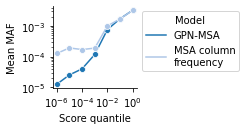

In [30]:
plt.figure(figsize=(1.5,1.5))
g = sns.lineplot(
    data=df.replace("MSA", "MSA column\nfrequency"),
    x="score_bin",
    y="Mean MAF",
    hue="Model",
    errorbar=None,
    palette=sns.color_palette("tab20")[:2],
    marker="o",
)
plt.xlabel("Score quantile")
#title = f"gnomAD bi-allelic\nn={format_number(len(V))}"
#title = f"gnomAD (n={format_number(len(V))})"
#plt.title(title)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.despine();
g.set(
    xscale="log",
    yscale='log',
    xticks=quantiles[::2],
    #xticklabels=[r"$[0,10^{-6}]$", r"$(10^{-3},10^{-3}]$", r"$(10^{-1},1]$"],
);
#plt.savefig("../../../results/plots/gnomad_vs_column.svg", bbox_inches="tight")

## third version, cut into 20 bins? (different ranges)

In [108]:
dfs = []

for model in models:
    eps = 1e-4
    breaks = np.linspace(V[model].min() - eps, V[model].max() + eps, 11)
    labels = [str(i) for i in range(len(breaks) + 1)]
    V_m = V.with_columns(
        pl.col(model).cut(breaks, labels=labels).cast(int).alias("score_bin")
    )
    df = (
        V_m.group_by("score_bin")
        .agg(pl.mean("MAF").alias("Mean MAF"), pl.count("MAF").alias("count"))
        .sort("score_bin")
        .to_pandas()
    )
    df["Model"] = model
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df

,score_bin,Mean MAF,count,Model
0,1,0.000046,83575,GPN-MSA
1,2,0.000158,665578,GPN-MSA
2,3,0.000703,3014761,GPN-MSA
3,4,0.001580,25354398,GPN-MSA
4,5,0.002111,230503877,GPN-MSA
5,6,0.003757,210229749,GPN-MSA
6,7,0.010822,18164377,GPN-MSA
7,8,0.020575,676799,GPN-MSA
8,9,0.065631,6442,GPN-MSA
9,10,0.066042,159,GPN-MSA


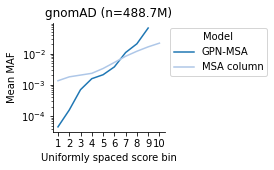

In [116]:
plt.figure(figsize=(2,2))
g = sns.lineplot(
    data=df[df["count"] >= 1000].replace("MSA", "MSA column"),  # 100 or 1000
    x="score_bin",
    y="Mean MAF",
    hue="Model",
    errorbar=None,
    palette=sns.color_palette("tab20")[:2],
)
plt.xlabel("Uniformly spaced score bin")
#plt.xlabel("Log-likelihood ratio")
#title = f"gnomAD bi-allelic\nn={format_number(len(V))}"
title = f"gnomAD (n={format_number(len(V))})"
plt.title(title)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.despine();
g.set(xticks=range(1, 11))
g.set(yscale='log');

In [123]:
# maybe just do correlation

In [129]:
V2 = V.select(models + ["MAF"]).to_pandas()
V2

,GPN-MSA,MSA,MAF
0,-0.017578,0.0,0.000023
1,-0.347656,0.0,0.000009
2,0.884766,0.0,0.000263
3,-0.432617,0.0,0.000017
4,0.074219,0.0,0.000028
...,...,...,...
488699710,0.460938,0.0,0.000044
488699711,0.205078,0.0,0.000094
488699712,0.023438,0.0,0.000054
488699713,2.310791,0.0,0.000164
